In [10]:
import numpy as np
from utils import mnist_reader

import plotly.express as px

from gtda.images import (
    Binarizer, Inverter,
    HeightFiltration, RadialFiltration,
    DilationFiltration, ErosionFiltration,
    SignedDistanceFiltration
)

from gtda.homology import CubicalPersistence

from gtda.diagrams import (
    Scaler, Filtering,
    PersistenceLandscape, BettiCurve, HeatKernel,
    PersistenceImage, Silhouette,
    Amplitude, PersistenceEntropy
)

from gtda.pipeline import Pipeline

from gtda.plotting import (
    plot_heatmap, plot_diagram, plot_betti_curves
)

# ML tools
from sklearn.cluster import DBSCAN # cluster algo
from sklearn.decomposition import PCA 
from sklearn.pipeline import FeatureUnion

In [11]:
x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [12]:
train_data = x_train.reshape((-1,28,28))
train_labels = np.array(y_train)
test_data = x_test.reshape((-1,28,28))
test_labels = np.array(y_test)

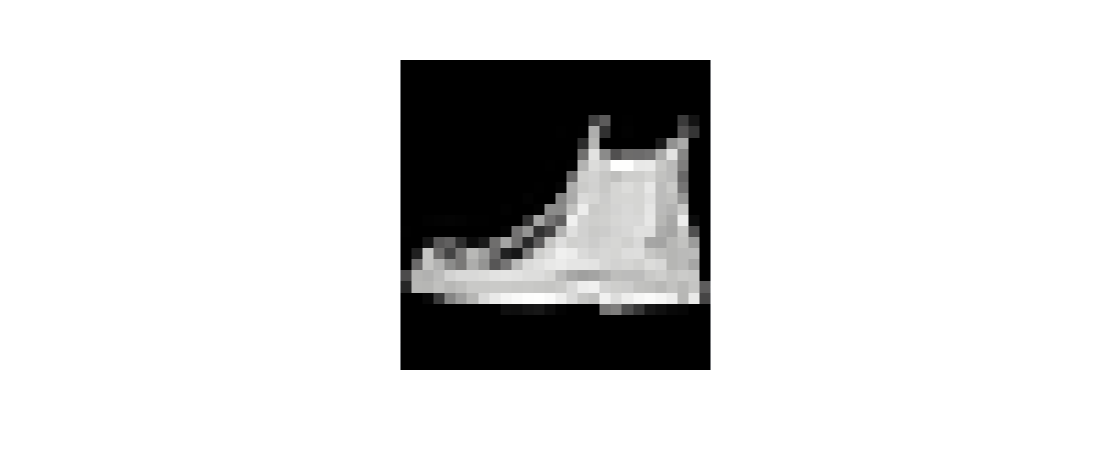

In [13]:
img = train_data[450]
fig = px.imshow(img, color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [16]:
import itertools

# Pipeline parameters
bin_thresholds = [0.25, 0.5, 0.75]
directions = [np.array([np.cos(t), np.sin(t)]) for t in np.linspace(0, 2 * np.pi, 7)[:-1]]

centers = [np.array(p) for p in itertools.product((7,14,21),(7,14,21))]
print(["{:.2f}_{:.2f}".format(*d) for d in directions])
print(["{}_{}".format(*c) for c in centers])

['1.00_0.00', '0.77_0.64', '0.17_0.98', '-0.50_0.87', '-0.94_0.34', '-0.94_-0.34', '-0.50_-0.87', '0.17_-0.98', '0.77_-0.64']
['7_7', '7_14', '7_21', '14_7', '14_14', '14_21', '21_7', '21_14', '21_21']


In [17]:
# Vectorizations, we use L^2 for kernels by default and default n_bins
# Note, we are not acutally using kernel vectors, just their amplitudes for now
features = [('bottleneck', Amplitude(metric='bottleneck', n_jobs=-1)), 
            #('wasserstein', Amplitude(metric='wasserstein')),
            ('landscape', Amplitude(metric='landscape', n_jobs=-1)),
            ('betti', Amplitude(metric='betti', n_jobs=-1)),
            #('silhouette', Amplitude(metric='silhouette')),
            #('heat_5', Amplitude(metric='heat', metric_params={'sigma': 5})),
            #('heat_10', Amplitude(metric='heat', metric_params={'sigma': 10})),
            #('PI_10', Amplitude(metric='persistence_image', metric_params={'sigma': 10})),
            #('PI_15', Amplitude(metric='persistence_image', metric_params={'sigma': 15})),
            ('PE', PersistenceEntropy(n_jobs=-1))]

# Make filtrations
binned_steps = [('bin_{}'.format(t), Binarizer(threshold=t, n_jobs=-1)) for t in bin_thresholds]

filtrations = [('height_{:.2f}_{:.2f}'.format(*d), HeightFiltration(direction=d, n_jobs=-1)) for d in directions]
filtrations.extend([('radial_{}_{}'.format(*c), RadialFiltration(center=c, n_jobs=-1)) for c in centers])
filtrations.append(('dilation', DilationFiltration(n_jobs=-1)))
filtrations.append(('erosion', ErosionFiltration(n_jobs=-1)))
filtrations.append(('signed', SignedDistanceFiltration(n_jobs=-1)))

# Make pipelines
cubical_lower = [('cubical', CubicalPersistence(n_jobs=-1))]
# cubical_upper = [('inverter', Inverter()), ('cubical', CubicalPersistence())]

partial_pipeline_steps = [cubical_lower]

for b, f in itertools.product(binned_steps, filtrations):
    partial_pipeline_steps.append([b, f, ('cubical', CubicalPersistence(n_jobs=-1))])
    
feature_pipelines = []
names = []
for s, f in itertools.product(partial_pipeline_steps, features):
    name = "{}_{}_{}".format(s[-3][0],s[-2][0], f[0]) if len(s) > 1 else "{}_{}".format(s[-1][0], f[0])
    names.append(name)
    feature_pipelines.append((name, Pipeline(s + [f])))
    
print(len(feature_pipelines))

full_pipeline = Pipeline([('features', FeatureUnion(feature_pipelines))])

256


In [22]:
# get small slice of data to play with
idx = np.random.randint(60000, size=2)
sandbox_data = train_data[idx,:]
sandbox_labels = train_labels[idx]
print(sandbox_labels)

[3 5]


In [21]:
features = full_pipeline.fit_transform(sandbox_data)

KeyboardInterrupt: 

In [ ]:
test_features = full_pipeline.fit_transform(test_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10000)
clf.fit(features, train_labels)

In [ ]:
clf.score(test_features, test_labels)

In [59]:
np.save('fashion_features', features)

In [60]:
np.save('fashion_test_features', features)